### **Heart Disease Prediction: Explainable AI with SHAP**


In [187]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [188]:
df = pd.read_csv('../data/heart.csv')
print("Original Shape:", df.shape)
print("Columns:", df.columns.tolist())


Original Shape: (920, 16)
Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


### Dataset Columns Description

- **id**: patient identifier  
- **age**: age of the patient  
- **gender**: biological sex  
- **dataset**: source dataset  
- **cp**: chest pain type  
- **trestbps**: resting blood pressure  
- **chol**: serum cholesterol  
- **fbs**: fasting blood sugar (> 120 mg/dl)  
- **restecg**: resting electrocardiographic results  
- **thalach**: maximum heart rate achieved  
- **exang**: exercise-induced angina  
- **oldpeak**: ST depression induced by exercise relative to rest  
- **slope**: slope of the peak exercise ST segment  
- **ca**: number of major vessels (0–3) colored by fluoroscopy  
- **thal**: thalassemia  
  - normal  
  - fixed defect  
  - reversible defect  
- **num**: predicted attribute (target variable)


#### Preprocessing

In [189]:

df = df.drop('id', axis=1)
df = df.drop('dataset', axis=1)
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop('num', axis=1)


df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

bool_map = {'TRUE': 1, 'FALSE': 0, True: 1, False: 0}
df['fbs'] = df['fbs'].map(bool_map)
df['exang'] = df['exang'].map(bool_map)

categorical_cols = ['cp', 'restecg', 'slope', 'thal']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"Processed Dataset Shape: {df.shape}")
df.head()


Processed Dataset Shape: (920, 19)


,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,ca,target,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,63,1,145.0,233.0,1.0,150.0,0.0,2.3,0.0,0,False,False,True,False,False,False,False,False,False
1,67,1,160.0,286.0,0.0,108.0,1.0,1.5,3.0,1,False,False,False,False,False,True,False,True,False
2,67,1,120.0,229.0,0.0,129.0,1.0,2.6,2.0,1,False,False,False,False,False,True,False,False,True
3,37,1,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,False,True,False,True,False,False,False,True,False
4,41,0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,True,False,False,False,False,False,True,True,False


In [190]:
shap.initjs()
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

### Correlation Heatmap


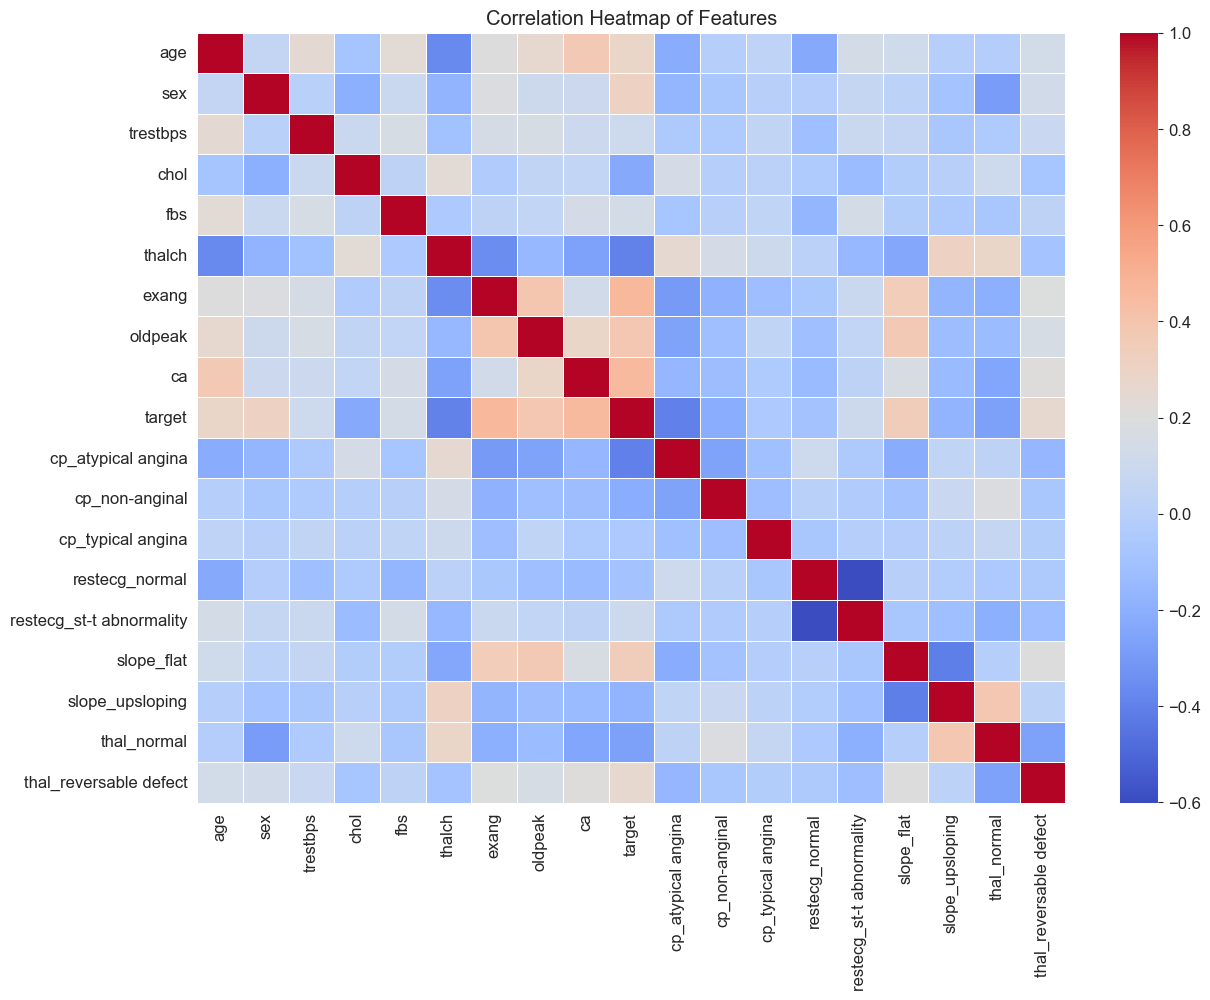

In [191]:
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()


### Distributions of Key Features


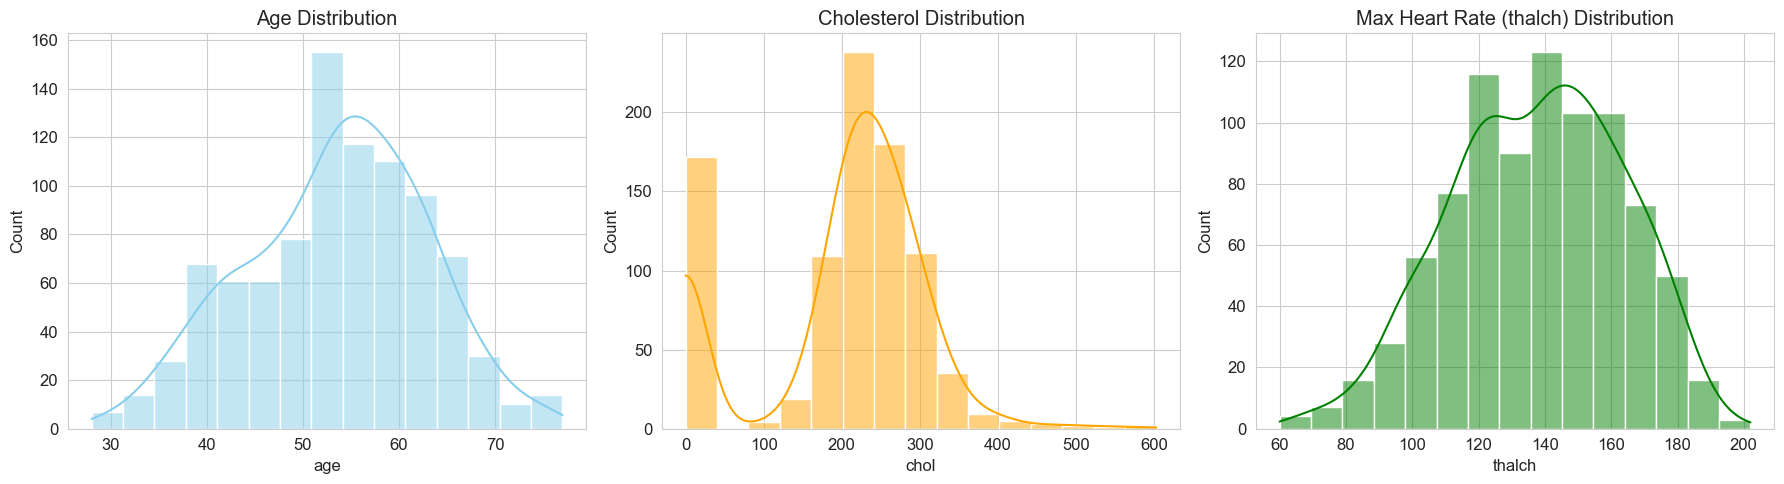

In [192]:
# only for some featres
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age
sns.histplot(df['age'], bins=15, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Age Distribution')

# Cholesterol
sns.histplot(df['chol'], bins=15, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Cholesterol Distribution')

# Max Heart Rate (thalch)
sns.histplot(df['thalch'], bins=15, kde=True, ax=axes[2], color='green')
axes[2].set_title('Max Heart Rate (thalch) Distribution')

plt.tight_layout()
plt.show()


### Model Training (XGBoost)


In [195]:
# remove target for the purpose of modeling
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [197]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2%}")
print("Classification Report:", classification_report(y_test, y_pred))

Model Accuracy: 88.04%
Classification Report:               precision    recall  f1-score   support

           0       0.81      0.92      0.86        75
           1       0.94      0.85      0.89       109

    accuracy                           0.88       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.88      0.88       184



### SHAP Analysis


In [198]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

print(f"SHAP Values Shape: {shap_values.shape}")


SHAP Values Shape: (184, 18)


## **Global Interpretability**

#### **Feature Importance Bar Plot**
This plot shows the **mean absolute SHAP value**. It tells us **which features matter most**, but not **how they matter**.


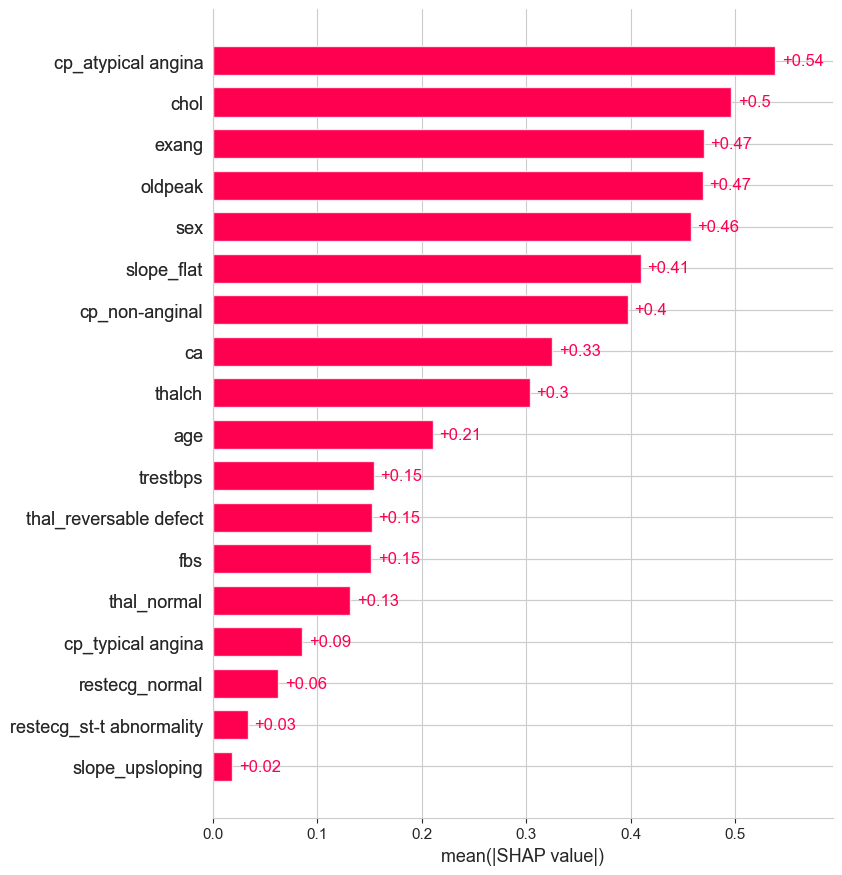

In [199]:
shap.plots.bar(shap_values, max_display=20)

### **Beeswarm Plot**

**Direction of Influence**

- **Y-axis:** Features ordered by importance  
- **X-axis:** SHAP values (impact on model output). Positive = Higher risk of disease  
- **Color:** Feature value (Red = High, Blue = Low)  

**Interpretation:**  
If the dots on the right (positive SHAP values) are **red**, it means a **high value** of that feature increases the risk of heart disease.


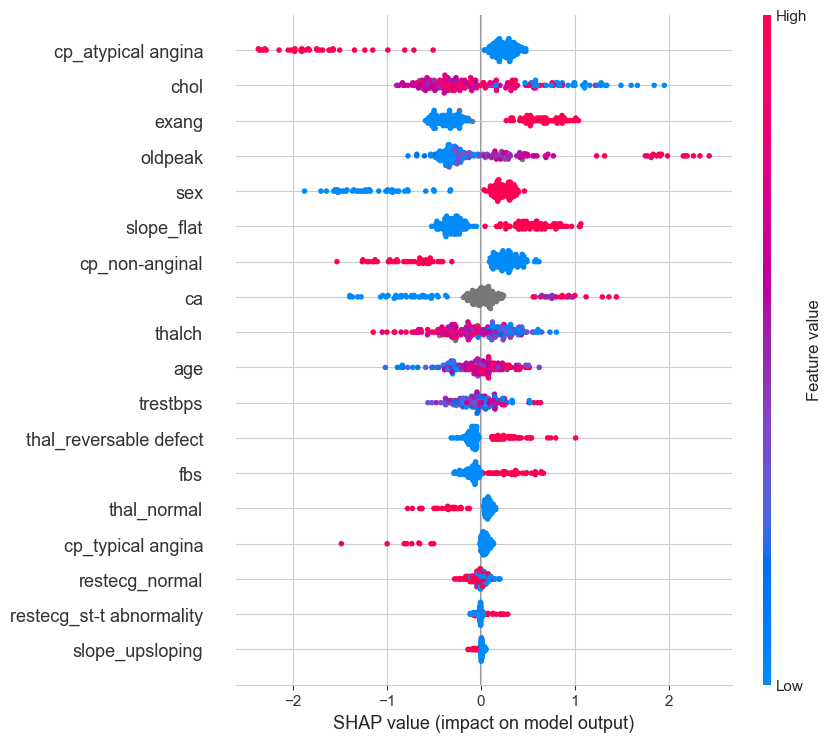

In [200]:
shap.plots.beeswarm(shap_values, max_display=20)

### Dependence Plot


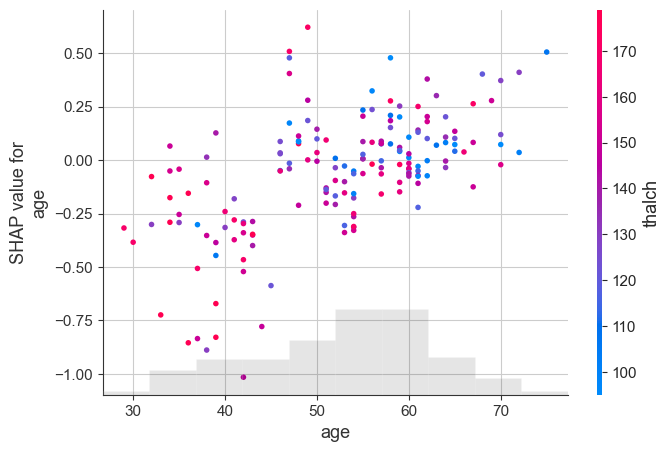

In [207]:
shap.plots.scatter(shap_values[:, "age"], color=shap_values[:, "thalch"])

### **Local Interpretability**


In [208]:
patient_idx = 0

actual = y_test.iloc[patient_idx]
pred = y_pred[patient_idx]
prob = model.predict_proba(X_test.iloc[[patient_idx]])[0][1]

print(f"Patient Index: {patient_idx}")
print(f"Actual Label: {'Disease' if actual==1 else 'Healthy'}")
print(f"Model Prediction: {'Disease' if pred==1 else 'Healthy'} (Probability: {prob:.2f})")

Patient Index: 0
Actual Label: Healthy
Model Prediction: Healthy (Probability: 0.01)


### **Waterfall Plot**


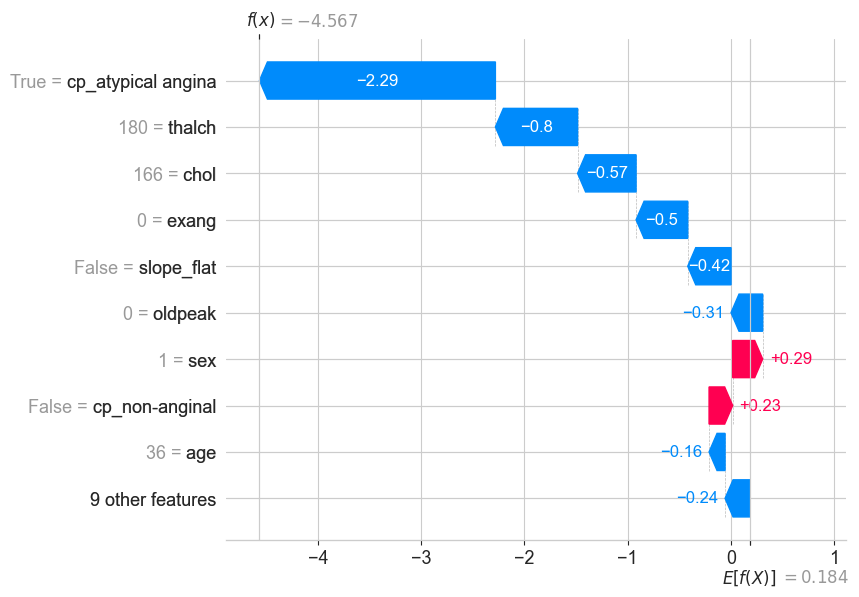

In [209]:
shap.plots.waterfall(shap_values[patient_idx], max_display=10)

### **Force Plot**
Similar to waterfall, but condensed. Red bars push the prediction higher (risk), Blue bars push it lower (healthy).


In [210]:
shap.plots.force(shap_values[0])

In [211]:
shap.plots.force(shap_values[:5])

### **Distinction Grade Analysis**


**Comparison: Native Feature Importance vs. SHAP**  
Standard XGBoost importance (Weight/Gain/cover) can be biased towards high-cardinality features. SHAP is generally more consistent.


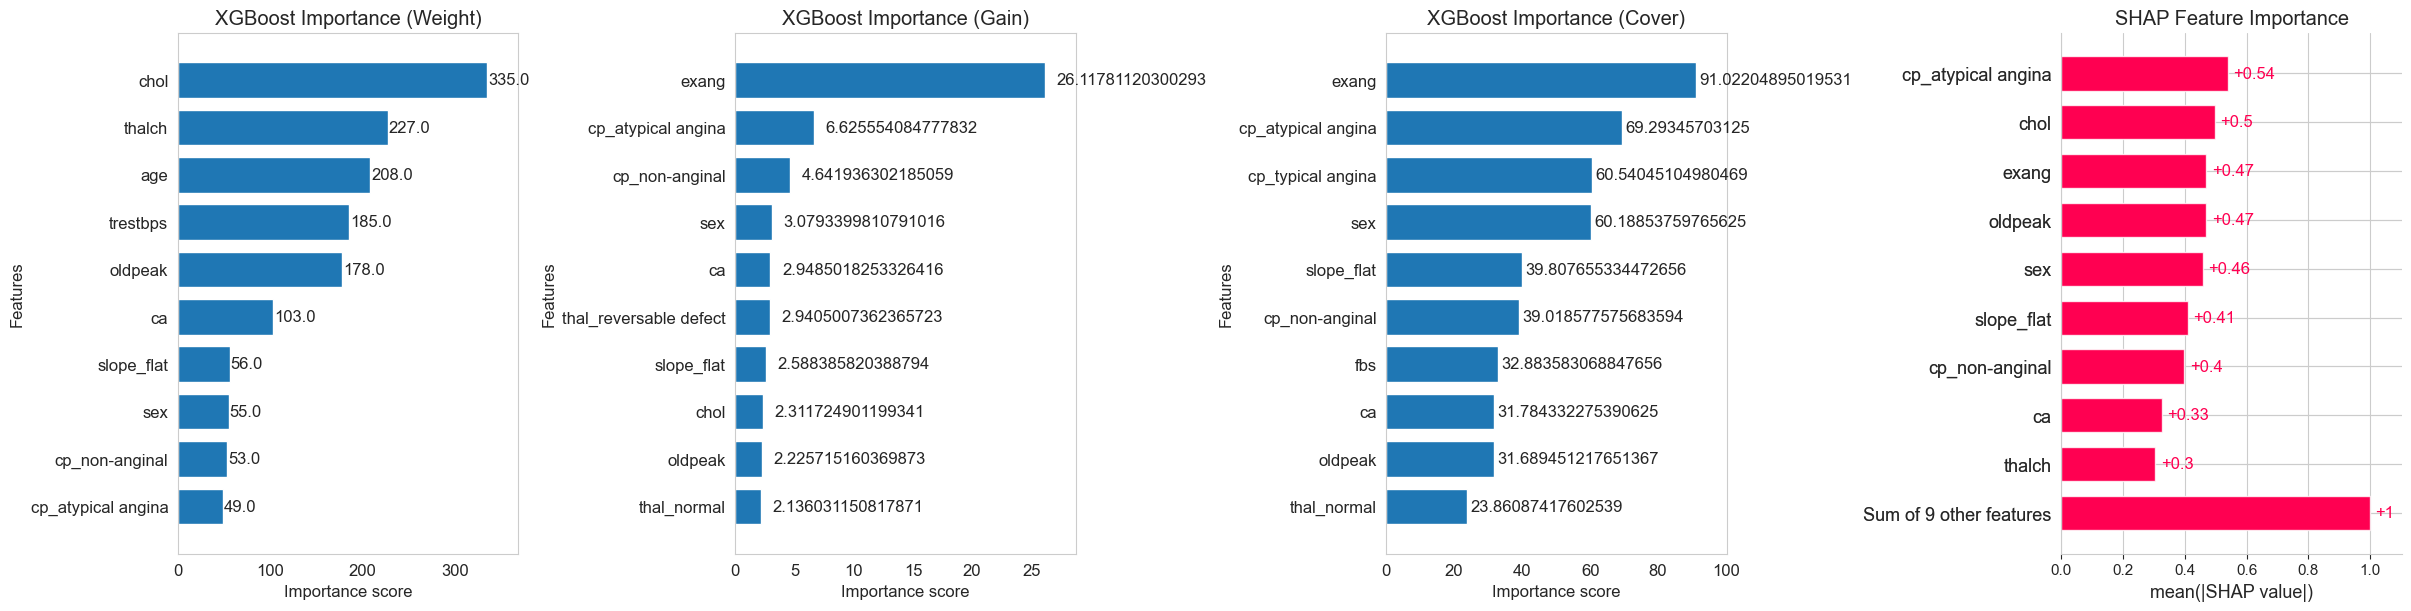

In [212]:
fig, axes = plt.subplots(
    1, 4,
    figsize=(24, 6),
    constrained_layout=True
)


for ax, imp, title in zip(axes[:3], ['weight', 'gain', 'cover'],['Weight', 'Gain', 'Cover']):
    xgb.plot_importance(
        model,
        importance_type=imp,
        max_num_features=10,
        ax=ax,
        height=0.75,
        grid=False
    )
    ax.set_title(f"XGBoost Importance ({title})")


shap.plots.bar(
    shap_values,
    max_display=10,
    show=False,
    ax=axes[3]
)
axes[3].set_title("SHAP Feature Importance")

plt.show()


### **Error Analysis**


For cases where the model failed (False Positive or False Negative) and use SHAP to understand the confusion.

idx 4


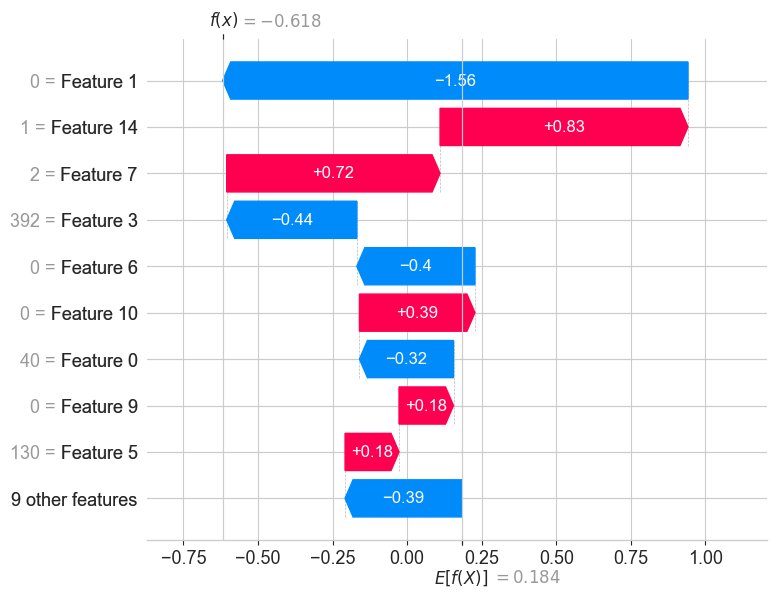

In [174]:
mistakes = np.where(y_test != y_pred)[0]

if len(mistakes) > 0:
    error_idx = mistakes[0]
    print("idx", error_idx)
    shap.plots.waterfall(shap_values[error_idx])
else:
    print("Aha, No mistakes found. It must must be a mistake 🤔")